## 数据预处理

#### 读取数据

In [1]:
import pandas as pd
import numpy as np

# 读取数据
data_titleInfo = pd.read_csv('../dataset/Data_TitleInfo.csv')
data_studentInfo = pd.read_csv('../dataset/Data_StudentInfo.csv')

data_submitRecords = [pd.read_csv('../dataset/Data_SubmitRecord/SubmitRecord-Class%d.csv' % i) for i in range(1, 16)]
for i in range(1, 16):
    data_submitRecords[i-1]['class'] = f'Class{i}'
# 合并submitRecords
data_submitRecords = pd.concat(data_submitRecords)
data_submitRecords = data_submitRecords.reset_index(drop=True)
# 把数据中的index列改为index
data_submitRecords.replace('--', 0, inplace=True)
data_submitRecords.replace('-', 0, inplace=True)
data_submitRecords['state'].replace('�������', 'Error10', inplace=True)
data_submitRecords['timeconsume'] = data_submitRecords['timeconsume'].astype('int64')
# data_submitRecords.to_csv('data_submitRecords.csv', index=False)

#### 生成题目数据特征

In [2]:
data_submitRecords.columns

Index(['index', 'class', 'time', 'state', 'score', 'title_ID', 'method',
       'memory', 'timeconsume', 'student_ID'],
      dtype='object')

In [3]:
# title 汇总信息
title_all_df = pd.DataFrame()
title_all_df['title_ID'] = data_titleInfo.groupby('title_ID')['title_ID'].max().values
title_all_df['score'] = data_titleInfo.groupby('title_ID')['score'].max().values
title_all_df['knowledge'] = data_titleInfo.groupby('title_ID')['knowledge'].aggregate(lambda x: ' '.join(x.tolist())).values
title_all_df['sub_knowledge'] = data_titleInfo.groupby('title_ID')['sub_knowledge'].aggregate(lambda x: ' '.join(x.tolist())).values
title_all_df['knowledge_num'] = data_titleInfo.groupby('title_ID')['knowledge'].count().values
title_all_df['sub_knowledge_num'] = data_titleInfo.groupby('title_ID')['sub_knowledge'].count().values
title_all_df['t_sbmnum'] = data_submitRecords.groupby('title_ID')['title_ID'].count().values
title_all_df['t_mean_sbmnum'] = title_all_df['t_sbmnum'] / [(data_submitRecords[data_submitRecords['title_ID'] == title_id]).groupby('student_ID')['student_ID'].count().values.shape[0] for title_id in title_all_df['title_ID']]
title_all_df['t_mean_score'] = data_submitRecords.groupby('title_ID')['score'].mean().values / title_all_df['score'] * 100
title_all_df['t_mean_pfm_mem'] = (data_submitRecords[data_submitRecords['memory'] != 0]).groupby('title_ID')['memory'].mean().values
title_all_df['t_max_pfm_mem'] = (data_submitRecords[data_submitRecords['memory'] != 0]).groupby('title_ID')['memory'].max().values
title_all_df['t_min_pfm_mem'] = (data_submitRecords[data_submitRecords['memory'] != 0]).groupby('title_ID')['memory'].min().values
title_all_df['t_mean_pfm_tc'] = (data_submitRecords[data_submitRecords['timeconsume'] != 0]).groupby('title_ID')['timeconsume'].mean().values
title_all_df['t_max_pfm_tc'] = (data_submitRecords[data_submitRecords['timeconsume'] != 0]).groupby('title_ID')['timeconsume'].max().values
title_all_df['t_min_pfm_tc'] = (data_submitRecords[data_submitRecords['timeconsume'] != 0]).groupby('title_ID')['timeconsume'].min().values
title_all_df['t_subtime_f'] = data_submitRecords.groupby('title_ID')['time'].min().values.astype('datetime64[s]')
title_all_df['t_subtime_l'] = data_submitRecords.groupby('title_ID')['time'].max().values.astype('datetime64[s]')
title_all_df['t_period'] = title_all_df['t_subtime_l'] - title_all_df['t_subtime_f']
title_all_df['t_methodNum'] = [(data_submitRecords[data_submitRecords['title_ID'] == title_id]).groupby('method')['method'].count().values for title_id in title_all_df['title_ID']]
title_all_df.insert(0, 'index', title_all_df.index)
title_all_df.to_csv('./题目数据特征/titles_all.csv', index=False)


In [4]:
# title 分班信息
title_sep_dfs = []
for i in range(1, 16):
    cur_class_records = data_submitRecords[data_submitRecords['class'] == f'Class{i}']
    title_df = pd.DataFrame()
    title_df['title_ID'] = data_titleInfo.groupby('title_ID')['title_ID'].max().values
    title_df['score'] = data_titleInfo.groupby('title_ID')['score'].max().values
    title_df['knowledge'] = data_titleInfo.groupby('title_ID')['knowledge'].aggregate(lambda x: ' '.join(x.tolist())).values
    title_df['sub_knowledge'] = data_titleInfo.groupby('title_ID')['sub_knowledge'].aggregate(lambda x: ' '.join(x.tolist())).values
    title_df['knowledge_num'] = data_titleInfo.groupby('title_ID')['knowledge'].count().values
    title_df['sub_knowledge_num'] = data_titleInfo.groupby('title_ID')['sub_knowledge'].count().values
    title_df['t_sbmnum'] = cur_class_records.groupby('title_ID')['title_ID'].count().values
    title_df['t_mean_sbmnum'] = title_df['t_sbmnum'] / [(cur_class_records[cur_class_records['title_ID'] == title_id]).groupby('student_ID')['student_ID'].count().values.shape[0] for title_id in title_df['title_ID']]
    title_df['t_mean_score'] = cur_class_records.groupby('title_ID')['score'].mean().values / title_df['score'] * 100
    title_df['t_mean_pfm_mem'] = (cur_class_records[cur_class_records['memory'] != 0]).groupby('title_ID')['memory'].mean().values
    title_df['t_max_pfm_mem'] = (cur_class_records[cur_class_records['memory'] != 0]).groupby('title_ID')['memory'].max().values
    title_df['t_min_pfm_mem'] = (cur_class_records[cur_class_records['memory'] != 0]).groupby('title_ID')['memory'].min().values
    title_df['t_mean_pfm_tc'] = (cur_class_records[cur_class_records['timeconsume'] != 0]).groupby('title_ID')['timeconsume'].mean().values
    title_df['t_max_pfm_tc'] = (cur_class_records[cur_class_records['timeconsume'] != 0]).groupby('title_ID')['timeconsume'].max().values
    title_df['t_min_pfm_tc'] = (cur_class_records[cur_class_records['timeconsume'] != 0]).groupby('title_ID')['timeconsume'].min().values
    title_df['t_subtime_f'] = cur_class_records.groupby('title_ID')['time'].min().values.astype('datetime64[s]')
    title_df['t_subtime_l'] = cur_class_records.groupby('title_ID')['time'].max().values.astype('datetime64[s]')
    title_df['t_period'] = title_df['t_subtime_l'] - title_df['t_subtime_f']
    title_df['t_methodNum'] = [(cur_class_records[cur_class_records['title_ID'] == title_id]).groupby('method')['method'].count().values for title_id in title_df['title_ID']]
    title_df.insert(0, 'index', title_df.index)
    title_sep_dfs.append(title_df)
    title_df.to_csv(f'./题目数据特征/titles_class{i}.csv', index=False)

In [5]:
title_sep_df = pd.DataFrame()
title_sep_df['title_ID'] = data_titleInfo.groupby('title_ID')['title_ID'].max().values
title_sep_df['score'] = data_titleInfo.groupby('title_ID')['score'].max().values
title_sep_df['knowledge'] = data_titleInfo.groupby('title_ID')['knowledge'].aggregate(lambda x: ' '.join(x.tolist())).values
title_sep_df['sub_knowledge'] = data_titleInfo.groupby('title_ID')['sub_knowledge'].aggregate(lambda x: ' '.join(x.tolist())).values
title_sep_df['knowledge_num'] = data_titleInfo.groupby('title_ID')['knowledge'].count().values
title_sep_df['sub_knowledge_num'] = data_titleInfo.groupby('title_ID')['sub_knowledge'].count().values
for col in title_all_df.columns:
    if 't_' in col:
        title_sep_df[col] = np.concatenate(tuple([title_sep_dfs[i][col].to_numpy().reshape(-1, 1) for i in range(15)]), axis=1).tolist()
title_sep_df.insert(0, 'index', title_sep_df.index)
# title_sep_df.to_csv('titles_sep.csv', index=False)

#### 计算人-题数据

In [6]:
# student学号列表
stu_ids = data_studentInfo['student_ID'].values.tolist()
stu_ids = list(set(stu_ids))
stu_ids.sort()
# title题目列表
title_ids = data_titleInfo['title_ID'].values.tolist()
title_ids = list(set(title_ids))
title_ids.sort()

In [7]:
def get_title_attribute(title_id, attribute):
    return title_all_df[title_all_df['title_ID'] == title_id][attribute].values[0]

In [94]:
# 计算人题数据
stu_title_df = pd.DataFrame(columns=['title_ID', 'student_ID', 'class', 'st_score', 'st_pfm_tc', 'st_pfm_mem', 'st_errs', 'st_testNum', 'st_exploreNum', 'st_time_f', 'st_time_best', 'st_time_l', 'st_time_mean'])

from tqdm import tqdm
for title_id in title_ids:
    title_info = {}
    title_info['score'] = get_title_attribute(title_id, 'score')
    filtered_submits = data_submitRecords[(data_submitRecords['title_ID'] == title_id) & (data_submitRecords['score'] == title_info['score'])]
    title_info['ac_tc_min'] = filtered_submits['timeconsume'].min()
    title_info['ac_tc_max'] = filtered_submits['timeconsume'].max()
    title_info['ac_mem_min'] = filtered_submits['memory'].min()
    title_info['ac_mem_max'] = filtered_submits['memory'].max()
    for i in range(1, 16):
        filtered_submits = data_submitRecords[(data_submitRecords['title_ID'] == title_id) & (data_submitRecords['class'] == f'Class{i}')]
        title_info[f'Class{i}'] = [filtered_submits['time'].min(), filtered_submits['time'].max(), filtered_submits['time'].max() - filtered_submits['time'].min()]
    for student_id in tqdm(stu_ids):
        cur_row = {}
        cur_row['title_ID'] = title_id
        cur_row['student_ID'] = student_id
        filtered_submits = data_submitRecords[(data_submitRecords['student_ID'] == student_id) & (data_submitRecords['title_ID'] == title_id)].sort_values(by='time')
        if filtered_submits.shape[0] == 0:
            continue
        cur_row['class'] = filtered_submits['class'].values[0]
        # st_score
        max_score = filtered_submits['score'].max()
        cur_row['st_score'] = max_score / title_info['score']
        # st_pfm_tc & st_pfm_mem
        if cur_row['st_score'] == 1:
            best_tc = filtered_submits[filtered_submits['score'] == max_score]['timeconsume'].min()
            best_mem = filtered_submits[filtered_submits['score'] == max_score]['memory'].min()
            cur_row['st_pfm_tc'] = 1 - ((best_tc - title_info['ac_tc_min']) / (title_info['ac_tc_max'] - title_info['ac_tc_min']))
            cur_row['st_pfm_mem'] = 1 - ((best_mem - title_info['ac_mem_min']) / (title_info['ac_mem_max'] - title_info['ac_mem_min']))
        else:
            cur_row['st_pfm_tc'] = 0
            cur_row['st_pfm_mem'] = 0
        # st_errs
        cur_row['st_errs'] = np.unique(filtered_submits[filtered_submits['state'] != 'Absolutely_Correct']['state']).shape[0]
        # st_testNum & st_exploreNum
        submit_num = filtered_submits.shape[0]
        if (filtered_submits['state'] == 'Absolutely_Correct').max():
            # 有ac
            cur_row['st_testNum'] = (filtered_submits['state'] == 'Absolutely_Correct').astype(int).argmax()
            cur_row['st_exploreNum'] = submit_num - 1 - cur_row['st_testNum']
        else:
            # 没ac
            cur_row['st_testNum'] = submit_num
            cur_row['st_exploreNum'] = 0
        # st_time_*
        cur_row['st_time_f'] = (filtered_submits['time'].min() - title_info[cur_row['class']][0]) / title_info[cur_row['class']][2]
        cur_row['st_time_l'] = (filtered_submits['time'].max() - title_info[cur_row['class']][0]) / title_info[cur_row['class']][2]
        cur_row['st_time_mean'] = (filtered_submits['time'].mean() - title_info[cur_row['class']][0]) / title_info[cur_row['class']][2]
        cur_row['st_time_best'] = (filtered_submits[filtered_submits['score'] == max_score]['time'].min() - title_info[cur_row['class']][0]) / title_info[cur_row['class']][2]
        cur_row = pd.DataFrame([cur_row])
        stu_title_df = pd.concat([stu_title_df, cur_row], ignore_index=True)
stu_title_df.to_csv('./人题数据/stu_title.csv', index=False)



100%|██████████| 1364/1364 [01:06<00:00, 20.39it/s]


In [97]:
stu_title_df.drop(columns=['st_time_bestst_time_l'], inplace=True)
stu_title_df.to_csv('./人题数据/stu_title.csv', index=False)

In [106]:
# 添加排名信息
stu_title_df['st_rank'] = 0
for row_id, row in tqdm(stu_title_df.iterrows()):
    cur_title_id = row['title_ID']
    cur_class = row['class']
    cur_score = row['st_score']
    cur_student_id = row['student_ID']
    cur_class_df = stu_title_df[(stu_title_df['title_ID'] == cur_title_id) & (stu_title_df['class'] == cur_class)]
    cur_class_df = cur_class_df.sort_values(by=['st_score', 'st_time_best'], ascending=[False, True])
    row['st_rank'] = (cur_class_df['student_ID'] == cur_student_id).astype(int).argmax()
    row['st_rank'] /= (cur_class_df.shape[0] - 1)
    stu_title_df.loc[row_id, 'st_rank'] = row['st_rank']

50482it [04:10, 201.51it/s]


In [ ]:
# 添加题目分值
stu_title_df.insert(1, 'score', 0)

In [119]:
for title_id in title_ids:
    score = get_title_attribute(title_id, 'score')
    stu_title_df.loc[stu_title_df['title_ID'] == title_id, 'score'] = score
stu_title_df.to_csv('./人题数据/stu_title.csv', index=False)

In [16]:
stu_title_df = pd.read_csv('./人题数据/stu_title.csv')
stu_title_df

,title_ID,score,student_ID,class,st_score,st_pfm_tc,st_pfm_mem,st_errs,st_testNum,st_exploreNum,st_time_f,st_time_mean,st_time_l,st_time_best,st_rank
0,Question_3MwAFlmNO8EKrpY5zjUd,2,0088dc183f73c83f763e,Class2,1.0,0.896552,0.681034,2,22,0,0.218173,0.218499,0.218732,0.218732,0.417582
1,Question_3MwAFlmNO8EKrpY5zjUd,2,00cbf05221bb479e66c3,Class10,1.0,0.965517,0.646552,4,8,0,0.083201,0.083365,0.083447,0.083447,0.084337
2,Question_3MwAFlmNO8EKrpY5zjUd,2,00df647ee4bf7173642f,Class14,1.0,0.931034,0.551724,3,19,3,0.252974,0.253360,0.254449,0.253368,0.367089
3,Question_3MwAFlmNO8EKrpY5zjUd,2,0107f72b66cbd1a0926d,Class5,1.0,0.931034,0.689655,1,5,0,0.116677,0.122525,0.151701,0.151701,0.192771
4,Question_3MwAFlmNO8EKrpY5zjUd,2,011d454f199c123d44ad,Class3,1.0,1.000000,0.948276,1,10,0,0.558886,0.612414,0.624164,0.624164,0.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50477,Question_xqlJkmRaP0otZcX4fK3W,3,zq3xohaut5o9dbd9064z,Class6,0.0,0.000000,0.000000,2,4,0,0.679536,0.751238,0.870018,0.679536,0.831461
50478,Question_xqlJkmRaP0otZcX4fK3W,3,zse4s5wowlo5xntqyqb4,Class10,1.0,0.954545,0.982609,2,0,5,0.000746,0.682666,0.878807,0.000746,0.024096
50479,Question_xqlJkmRaP0otZcX4fK3W,3,zuw35j06tzftt6oon4c5,Class6,0.0,0.000000,0.000000,2,2,0,0.794678,0.832328,0.869978,0.794678,0.932584
50480,Question_xqlJkmRaP0otZcX4fK3W,3,zyfp520tbnq5p2pvrkin,Class2,0.0,0.000000,0.000000,2,2,0,0.513081,0.672036,0.830990,0.513081,0.833333


In [23]:
stu_title_features_df = pd.DataFrame(columns=['title_ID', 'score', 'student_ID', 'score_bonus', 'tc_bonus', 'mem_bonus', '_error_type_penalty', '_test_num_penalty', 'explore_bonus', 'enthusiasm_bonus', 'rank_bonus'])

from tqdm import tqdm
for title_id in tqdm(title_ids):
    for stu_id in stu_ids:
        row = stu_title_df[(stu_title_df['title_ID'] == title_id) & (stu_title_df['student_ID'] == stu_id)]
        cur_row = {}
        cur_row['title_ID'] = title_id
        cur_row['score'] = data_titleInfo[data_titleInfo['title_ID'] == title_id]['score'].values[0]
        cur_row['student_ID'] = stu_id
        if(row.shape[0] == 0):
            for key in stu_title_features_df.columns.values[3:]:
                cur_row[key] = 0
        else:
            cur_row['score_bonus'] = row['st_score'].values[0]
            cur_row['tc_bonus'] = row['st_pfm_tc'].values[0]
            cur_row['mem_bonus'] = row['st_pfm_mem'].values[0]
            errs_num_min = stu_title_df[stu_title_df['title_ID'] == title_id]['st_errs'].min()
            errs_num_max = stu_title_df[stu_title_df['title_ID'] == title_id]['st_errs'].max()
            cur_row['_error_type_penalty'] = 1 - ((row['st_errs'].values[0] - errs_num_min) / (errs_num_max - errs_num_min))
            test_num_min = stu_title_df[stu_title_df['title_ID'] == title_id]['st_testNum'].min()
            test_num_max = stu_title_df[stu_title_df['title_ID'] == title_id]['st_testNum'].max()
            cur_row['_test_num_penalty'] = 1 - ((row['st_testNum'].values[0] - test_num_min) / (test_num_max - test_num_min))
            explore_num_min = stu_title_df[stu_title_df['title_ID'] == title_id]['st_exploreNum'].min()
            explore_num_max = stu_title_df[stu_title_df['title_ID'] == title_id]['st_exploreNum'].max()
            cur_row['explore_bonus'] = ((row['st_exploreNum'].values[0] - explore_num_min) / (explore_num_max - explore_num_min))
            cur_row['enthusiasm_bonus'] = 1 - row['st_time_mean'].values[0]
            cur_row['rank_bonus'] = 1 - row['st_rank'].values[0]
        
        cur_row = pd.DataFrame([cur_row])
        stu_title_features_df = pd.concat([stu_title_features_df, cur_row], ignore_index=True)

100%|██████████| 38/38 [16:31<00:00, 26.09s/it]


In [26]:
stu_title_features_df.to_csv('./人题数据/stu_title_features.csv', index=False)

#### 学生特征数据

In [29]:
stu_df = pd.DataFrame(columns=stu_title_features_df.columns.values[2:])
for stu_id in tqdm(stu_ids):
    cur_row = {}
    cur_row['student_ID'] = stu_id
    filtered_df = stu_title_features_df[stu_title_features_df['student_ID'] == stu_id]
    for key in stu_df.columns.values[1:]:
        cur_row[key] = (filtered_df[key].values * filtered_df['score'].values).sum() / filtered_df['score'].sum()
    cur_row = pd.DataFrame([cur_row])
    stu_df = pd.concat([stu_df, cur_row], ignore_index=True)

100%|██████████| 1364/1364 [00:04<00:00, 303.63it/s]


In [30]:
data_studentInfo.sort_values(by='student_ID', inplace=True)
stu_df.insert(1, 'major', data_studentInfo['major'].values)

In [32]:
stu_classes = []
for stu_id in stu_df['student_ID']:
    stu_classes.append(data_submitRecords[data_submitRecords['student_ID'] == stu_id]['class'].values[0])
stu_df.insert(1, 'class', stu_classes)
stu_df

,student_ID,class,major,score_bonus,tc_bonus,mem_bonus,_error_type_penalty,_test_num_penalty,explore_bonus,enthusiasm_bonus,rank_bonus
0,0088dc183f73c83f763e,Class2,J40192,1.00,0.950476,0.741791,0.759333,0.933718,0.008941,0.462128,0.446378
1,00cbf05221bb479e66c3,Class10,J23517,1.00,0.911420,0.724297,0.651762,0.925473,0.009545,0.440789,0.503997
2,00df647ee4bf7173642f,Class14,J57489,1.00,0.915866,0.670086,0.579214,0.793009,0.029498,0.710928,0.721258
3,0107f72b66cbd1a0926d,Class5,J87654,1.00,0.948442,0.778892,0.832524,0.966304,0.001622,0.557334,0.674238
4,011d454f199c123d44ad,Class3,J78901,1.00,0.969072,0.759228,0.735310,0.917201,0.007013,0.263143,0.387578
...,...,...,...,...,...,...,...,...,...,...,...
1359,zq3xohaut5o9dbd9064z,Class6,J57489,0.60,0.508240,0.399747,0.638310,0.918973,0.027557,0.520000,0.358133
1360,zse4s5wowlo5xntqyqb4,Class10,J40192,0.82,0.689271,0.546344,0.688833,0.971432,0.094519,0.545948,0.538191
1361,zuw35j06tzftt6oon4c5,Class6,J40192,0.71,0.609947,0.466892,0.597190,0.934127,0.078511,0.529821,0.504526
1362,zyfp520tbnq5p2pvrkin,Class2,J23517,0.77,0.693359,0.581136,0.678524,0.943027,0.058557,0.481266,0.444475


In [33]:
stu_df.to_csv('./人题数据/stu_features.csv', index=False)

#### 聚类

In [57]:
stu_df = pd.read_csv('./人题数据/stu.csv')
stu_df

,student_ID,sex,age,major,class,st_score,st_pfm_tc,st_pfm_mem,st_errs,st_testNum,st_exploreNum,st_time_f,st_time_mean,st_time_l,st_time_best,st_rank
0,0088dc183f73c83f763e,female,20,J40192,Class2,1.000000,0.950476,0.741791,1.330000,3.870000,0.160000,0.513852,0.537872,0.560742,0.540857,0.553622
1,00cbf05221bb479e66c3,female,19,J23517,Class10,1.000000,0.911420,0.724297,1.930000,4.060000,0.380000,0.552667,0.559211,0.562357,0.562006,0.496003
2,00df647ee4bf7173642f,male,23,J57489,Class14,1.000000,0.915866,0.670086,2.390000,11.370000,0.750000,0.264084,0.289072,0.341979,0.338754,0.278742
3,0107f72b66cbd1a0926d,female,20,J87654,Class5,1.000000,0.948442,0.778892,0.990000,1.970000,0.060000,0.433713,0.442666,0.452027,0.452026,0.325762
4,011d454f199c123d44ad,male,22,J78901,Class3,1.000000,0.969072,0.759228,1.450000,4.390000,0.090000,0.732619,0.736857,0.740483,0.740481,0.612422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,zq3xohaut5o9dbd9064z,male,19,J57489,Class6,0.625000,0.529416,0.416403,1.916667,2.354167,0.822917,0.287699,0.458334,0.628418,0.426168,0.626945
1360,zse4s5wowlo5xntqyqb4,female,24,J40192,Class10,0.820000,0.689271,0.546344,1.760000,1.450000,2.030000,0.230624,0.454052,0.653396,0.375032,0.461809
1361,zuw35j06tzftt6oon4c5,female,19,J40192,Class6,0.731959,0.628812,0.481332,2.154639,1.958763,1.628866,0.247226,0.453793,0.647750,0.366770,0.479870
1362,zyfp520tbnq5p2pvrkin,female,18,J23517,Class2,0.793814,0.714803,0.599110,1.701031,1.381443,1.721649,0.382263,0.503850,0.634502,0.457068,0.541778


In [59]:
students_df = stu_df.copy()

cols = students_df.columns
numeric_features = cols[5:]

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans


# 标准化数值特征
scaler = StandardScaler()
students_df[numeric_features] = scaler.fit_transform(students_df[numeric_features])

# 使用 K-prototypes 进行聚类
data_for_clustering = students_df[cols[5:]].values.astype(object)

c:\Users\QishuoBai\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\QishuoBai\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\QishuoBai\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\QishuoBai\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL

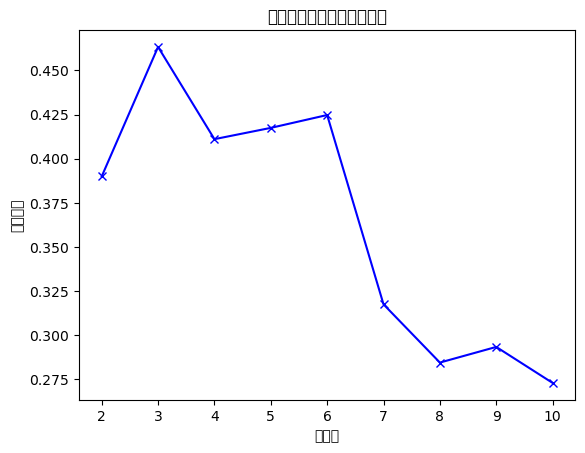

In [9]:
from sklearn.metrics import silhouette_score

# 使用 Silhouette Score 来确定最佳聚类数
silhouette_scores = []

# 遍历不同的聚类数
for k in range(2, 11):
    # kproto = KPrototypes(n_clusters=k, init='Huang', n_init=10, verbose=1)
    kmeans = KMeans(n_clusters=k, random_state=42)
    # clusters = kproto.fit_predict(data_for_clustering, categorical=[0, 1, 2, 3])
    clusters = kmeans.fit_predict(data_for_clustering)
    # 计算轮廓系数
    # numeric_part = data_for_clustering[:, 4:].astype(float)
    numeric_part = data_for_clustering.astype(float)
    score = silhouette_score(numeric_part, clusters)
    silhouette_scores.append(score)

import matplotlib.pyplot as plt
# 绘制 Silhouette Scores 图
plt.plot(range(2, 11), silhouette_scores, 'bx-')
plt.xlabel('聚类数')
plt.ylabel('轮廓系数')
plt.title('轮廓系数来确定最佳聚类数')
plt.show()

In [60]:
# kproto = KPrototypes(n_clusters=3, init='Huang', n_init=10, verbose=1)
# clusters = kproto.fit_predict(data_for_clustering, categorical=[0, 1, 2, 3])

clusters_list = []
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(data_for_clustering)
    clusters_list.append(clusters.tolist())

clusters_list = np.array(clusters_list)
clusters_list = np.transpose(clusters_list)

# students_df['cluster'] = clusters

c:\Users\QishuoBai\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\QishuoBai\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\QishuoBai\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\QishuoBai\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memor

In [61]:
students_df['cluster'] = clusters_list.tolist()

In [62]:
students_df

,student_ID,sex,age,major,class,st_score,st_pfm_tc,st_pfm_mem,st_errs,st_testNum,st_exploreNum,st_time_f,st_time_mean,st_time_l,st_time_best,st_rank,cluster
0,0088dc183f73c83f763e,female,20,J40192,Class2,0.769672,0.847143,0.786074,-0.061554,0.479871,-0.713464,0.407659,0.145963,-0.202530,0.272967,0.269652,"[0, 0, 2, 2, 3]"
1,00cbf05221bb479e66c3,female,19,J23517,Class10,0.769672,0.620669,0.660697,0.945760,0.565203,-0.469026,0.595767,0.269127,-0.193633,0.387033,-0.037006,"[0, 0, 2, 2, 3]"
2,00df647ee4bf7173642f,male,23,J57489,Class14,0.769672,0.646450,0.272170,1.718035,3.848213,-0.057925,-0.802786,-1.290012,-1.407811,-0.817045,-1.193308,"[0, 0, 1, 3, 4]"
3,0107f72b66cbd1a0926d,female,20,J87654,Class5,0.769672,0.835345,1.051968,-0.632366,-0.373442,-0.824573,0.019284,-0.403530,-0.801501,-0.206127,-0.943055,"[0, 0, 1, 2, 3]"
4,011d454f199c123d44ad,male,22,J78901,Class3,0.769672,0.954975,0.911039,0.139908,0.713410,-0.791240,1.467863,1.294429,0.787762,1.349613,0.582591,"[0, 0, 2, 0, 2]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,zq3xohaut5o9dbd9064z,male,19,J57489,Class6,-1.775190,-1.594420,-1.545953,0.923376,-0.200908,0.023092,-0.688340,-0.313099,0.170335,-0.345593,0.659883,"[0, 1, 0, 1, 1]"
1360,zse4s5wowlo5xntqyqb4,female,24,J40192,Class10,-0.451862,-0.667487,-0.614678,0.660354,-0.606980,1.364263,-0.964943,-0.337813,0.307951,-0.621386,-0.218993,"[0, 1, 0, 1, 1]"
1361,zuw35j06tzftt6oon4c5,female,19,J40192,Class6,-1.049336,-1.018066,-1.080613,1.322898,-0.378489,0.918569,-0.884487,-0.339309,0.276844,-0.665946,-0.122868,"[0, 1, 0, 1, 1]"
1362,zyfp520tbnq5p2pvrkin,female,18,J23517,Class2,-0.629565,-0.519436,-0.236513,0.561354,-0.637770,1.021659,-0.230056,-0.050399,0.203859,-0.178939,0.206615,"[0, 1, 0, 1, 1]"


c:\Users\QishuoBai\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


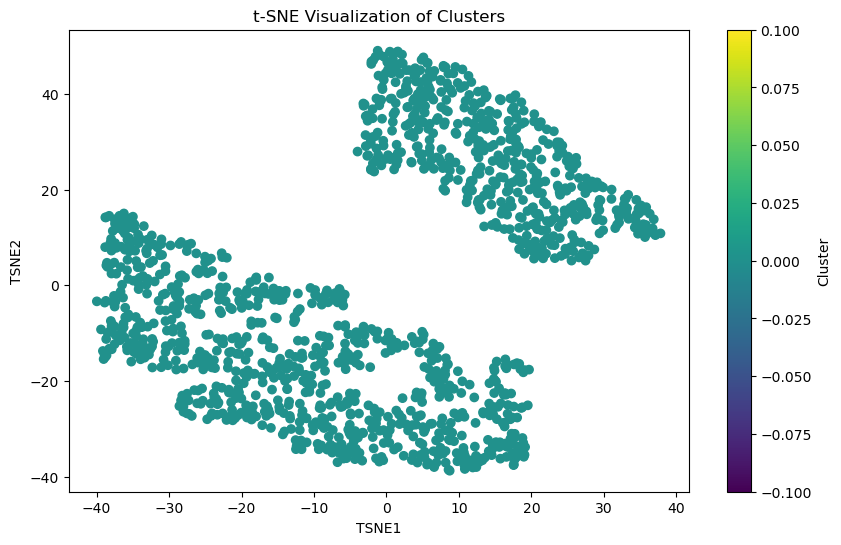

In [63]:
kmeans = KMeans(n_clusters=1, n_init=10, random_state=42)
clusters = kmeans.fit_predict(data_for_clustering)

from sklearn.manifold import TSNE

# 进行 PCA 降维到 2 维
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(students_df[students_df.columns[5:-1]])
# 创建一个包含 t-SNE 结果和聚类标签的新 DataFrame
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['cluster'] = clusters

# 可视化 t-SNE 结果
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['cluster'], cmap='viridis')
plt.colorbar(scatter, label='Cluster')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

In [65]:
stu_df['cluster'] = students_df['cluster']

In [69]:
stu_df['tsne_x'] = tsne_df['TSNE1']
stu_df['tsne_y'] = tsne_df['TSNE2']

In [70]:
stu_df

,student_ID,sex,age,major,class,st_score,st_pfm_tc,st_pfm_mem,st_errs,st_testNum,st_exploreNum,st_time_f,st_time_mean,st_time_l,st_time_best,st_rank,cluster,tsne_x,tsne_y
0,0088dc183f73c83f763e,female,20,J40192,Class2,1.000000,0.950476,0.741791,1.330000,3.870000,0.160000,0.513852,0.537872,0.560742,0.540857,0.553622,"[0, 0, 2, 2, 3]",-14.159333,-16.670208
1,00cbf05221bb479e66c3,female,19,J23517,Class10,1.000000,0.911420,0.724297,1.930000,4.060000,0.380000,0.552667,0.559211,0.562357,0.562006,0.496003,"[0, 0, 2, 2, 3]",-9.698304,-13.027369
2,00df647ee4bf7173642f,male,23,J57489,Class14,1.000000,0.915866,0.670086,2.390000,11.370000,0.750000,0.264084,0.289072,0.341979,0.338754,0.278742,"[0, 0, 1, 3, 4]",7.021459,-15.197865
3,0107f72b66cbd1a0926d,female,20,J87654,Class5,1.000000,0.948442,0.778892,0.990000,1.970000,0.060000,0.433713,0.442666,0.452027,0.452026,0.325762,"[0, 0, 1, 2, 3]",-4.955951,-31.300859
4,011d454f199c123d44ad,male,22,J78901,Class3,1.000000,0.969072,0.759228,1.450000,4.390000,0.090000,0.732619,0.736857,0.740483,0.740481,0.612422,"[0, 0, 2, 0, 2]",-18.061007,-1.290325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,zq3xohaut5o9dbd9064z,male,19,J57489,Class6,0.625000,0.529416,0.416403,1.916667,2.354167,0.822917,0.287699,0.458334,0.628418,0.426168,0.626945,"[0, 1, 0, 1, 1]",5.817047,41.483875
1360,zse4s5wowlo5xntqyqb4,female,24,J40192,Class10,0.820000,0.689271,0.546344,1.760000,1.450000,2.030000,0.230624,0.454052,0.653396,0.375032,0.461809,"[0, 1, 0, 1, 1]",21.772863,9.217066
1361,zuw35j06tzftt6oon4c5,female,19,J40192,Class6,0.731959,0.628812,0.481332,2.154639,1.958763,1.628866,0.247226,0.453793,0.647750,0.366770,0.479870,"[0, 1, 0, 1, 1]",12.821108,16.324409
1362,zyfp520tbnq5p2pvrkin,female,18,J23517,Class2,0.793814,0.714803,0.599110,1.701031,1.381443,1.721649,0.382263,0.503850,0.634502,0.457068,0.541778,"[0, 1, 0, 1, 1]",28.919033,13.605003


In [71]:
stu_df

,student_ID,sex,age,major,class,st_score,st_pfm_tc,st_pfm_mem,st_errs,st_testNum,st_exploreNum,st_time_f,st_time_mean,st_time_l,st_time_best,st_rank,cluster,tsne_x,tsne_y
0,0088dc183f73c83f763e,female,20,J40192,Class2,1.000000,0.950476,0.741791,1.330000,3.870000,0.160000,0.513852,0.537872,0.560742,0.540857,0.553622,"[0, 0, 2, 2, 3]",-14.159333,-16.670208
1,00cbf05221bb479e66c3,female,19,J23517,Class10,1.000000,0.911420,0.724297,1.930000,4.060000,0.380000,0.552667,0.559211,0.562357,0.562006,0.496003,"[0, 0, 2, 2, 3]",-9.698304,-13.027369
2,00df647ee4bf7173642f,male,23,J57489,Class14,1.000000,0.915866,0.670086,2.390000,11.370000,0.750000,0.264084,0.289072,0.341979,0.338754,0.278742,"[0, 0, 1, 3, 4]",7.021459,-15.197865
3,0107f72b66cbd1a0926d,female,20,J87654,Class5,1.000000,0.948442,0.778892,0.990000,1.970000,0.060000,0.433713,0.442666,0.452027,0.452026,0.325762,"[0, 0, 1, 2, 3]",-4.955951,-31.300859
4,011d454f199c123d44ad,male,22,J78901,Class3,1.000000,0.969072,0.759228,1.450000,4.390000,0.090000,0.732619,0.736857,0.740483,0.740481,0.612422,"[0, 0, 2, 0, 2]",-18.061007,-1.290325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,zq3xohaut5o9dbd9064z,male,19,J57489,Class6,0.625000,0.529416,0.416403,1.916667,2.354167,0.822917,0.287699,0.458334,0.628418,0.426168,0.626945,"[0, 1, 0, 1, 1]",5.817047,41.483875
1360,zse4s5wowlo5xntqyqb4,female,24,J40192,Class10,0.820000,0.689271,0.546344,1.760000,1.450000,2.030000,0.230624,0.454052,0.653396,0.375032,0.461809,"[0, 1, 0, 1, 1]",21.772863,9.217066
1361,zuw35j06tzftt6oon4c5,female,19,J40192,Class6,0.731959,0.628812,0.481332,2.154639,1.958763,1.628866,0.247226,0.453793,0.647750,0.366770,0.479870,"[0, 1, 0, 1, 1]",12.821108,16.324409
1362,zyfp520tbnq5p2pvrkin,female,18,J23517,Class2,0.793814,0.714803,0.599110,1.701031,1.381443,1.721649,0.382263,0.503850,0.634502,0.457068,0.541778,"[0, 1, 0, 1, 1]",28.919033,13.605003


In [83]:
stu_df.to_csv('./人题数据/stu_features.csv', index=False)

In [34]:
stu_df = pd.read_csv('./人题数据/stu_features.csv')
stu_df

,student_ID,class,major,score_bonus,tc_bonus,mem_bonus,_error_type_penalty,_test_num_penalty,explore_bonus,enthusiasm_bonus,rank_bonus
0,0088dc183f73c83f763e,Class2,J40192,1.00,0.950476,0.741791,0.759333,0.933718,0.008941,0.462128,0.446378
1,00cbf05221bb479e66c3,Class10,J23517,1.00,0.911420,0.724297,0.651762,0.925473,0.009545,0.440789,0.503997
2,00df647ee4bf7173642f,Class14,J57489,1.00,0.915866,0.670086,0.579214,0.793009,0.029498,0.710928,0.721258
3,0107f72b66cbd1a0926d,Class5,J87654,1.00,0.948442,0.778892,0.832524,0.966304,0.001622,0.557334,0.674238
4,011d454f199c123d44ad,Class3,J78901,1.00,0.969072,0.759228,0.735310,0.917201,0.007013,0.263143,0.387578
...,...,...,...,...,...,...,...,...,...,...,...
1359,zq3xohaut5o9dbd9064z,Class6,J57489,0.60,0.508240,0.399747,0.638310,0.918973,0.027557,0.520000,0.358133
1360,zse4s5wowlo5xntqyqb4,Class10,J40192,0.82,0.689271,0.546344,0.688833,0.971432,0.094519,0.545948,0.538191
1361,zuw35j06tzftt6oon4c5,Class6,J40192,0.71,0.609947,0.466892,0.597190,0.934127,0.078511,0.529821,0.504526
1362,zyfp520tbnq5p2pvrkin,Class2,J23517,0.77,0.693359,0.581136,0.678524,0.943027,0.058557,0.481266,0.444475


In [35]:
json_str = stu_df.to_json(orient='records')
# 指定要保存的 JSON 文件路径
json_file_path = './人题数据/stu_features.json'

# 将 JSON 字符串写入文件
with open(json_file_path, 'w') as json_file:
    json_file.write(json_str)

In [38]:
# 把json中的cluster改为正确的格式
import json

stu_features = json.load(open('./人题数据/stu_features.json', 'r'))
# for stu in stu_features:
#     stu['cluster'] = [int(i) for i in stu['cluster'][1:-1].split(',')]
stu_features

[{'student_ID': '0088dc183f73c83f763e',
  'class': 'Class2',
  'major': 'J40192',
  'score_bonus': 1.0,
  'tc_bonus': 0.9504763063,
  'mem_bonus': 0.7417914442,
  '_error_type_penalty': 0.7593333333,
  '_test_num_penalty': 0.9337177035,
  'explore_bonus': 0.0089411363,
  'enthusiasm_bonus': 0.4621283782,
  'rank_bonus': 0.4463775023},
 {'student_ID': '00cbf05221bb479e66c3',
  'class': 'Class10',
  'major': 'J23517',
  'score_bonus': 1.0,
  'tc_bonus': 0.9114197739,
  'mem_bonus': 0.724297491,
  '_error_type_penalty': 0.6517619048,
  '_test_num_penalty': 0.9254731669,
  'explore_bonus': 0.0095447152,
  'enthusiasm_bonus': 0.4407886654,
  'rank_bonus': 0.5039965076},
 {'student_ID': '00df647ee4bf7173642f',
  'class': 'Class14',
  'major': 'J57489',
  'score_bonus': 1.0,
  'tc_bonus': 0.9158657071,
  'mem_bonus': 0.6700862284,
  '_error_type_penalty': 0.5792142857,
  '_test_num_penalty': 0.7930090427,
  'explore_bonus': 0.0294980434,
  'enthusiasm_bonus': 0.7109277651,
  'rank_bonus': 0.7

In [39]:
# 把json中的features聚合
for stu in stu_features:
    stu['features'] = {}
    stu['features']['score_bonus'] = stu['score_bonus']
    stu['features']['tc_bonus'] = stu['tc_bonus']
    stu['features']['mem_bonus'] = stu['mem_bonus']
    stu['features']['_error_type_penalty'] = stu['_error_type_penalty']
    stu['features']['_test_num_penalty'] = stu['_test_num_penalty']
    stu['features']['explore_bonus'] = stu['explore_bonus']
    stu['features']['enthusiasm_bonus'] = stu['enthusiasm_bonus']
    stu['features']['rank_bonus'] = stu['rank_bonus']
    del stu['score_bonus']
    del stu['tc_bonus']
    del stu['mem_bonus']
    del stu['_error_type_penalty']
    del stu['_test_num_penalty']
    del stu['explore_bonus']
    del stu['enthusiasm_bonus']
    del stu['rank_bonus']
stu_features

[{'student_ID': '0088dc183f73c83f763e',
  'class': 'Class2',
  'major': 'J40192',
  'features': {'score_bonus': 1.0,
   'tc_bonus': 0.9504763063,
   'mem_bonus': 0.7417914442,
   '_error_type_penalty': 0.7593333333,
   '_test_num_penalty': 0.9337177035,
   'explore_bonus': 0.0089411363,
   'enthusiasm_bonus': 0.4621283782,
   'rank_bonus': 0.4463775023}},
 {'student_ID': '00cbf05221bb479e66c3',
  'class': 'Class10',
  'major': 'J23517',
  'features': {'score_bonus': 1.0,
   'tc_bonus': 0.9114197739,
   'mem_bonus': 0.724297491,
   '_error_type_penalty': 0.6517619048,
   '_test_num_penalty': 0.9254731669,
   'explore_bonus': 0.0095447152,
   'enthusiasm_bonus': 0.4407886654,
   'rank_bonus': 0.5039965076}},
 {'student_ID': '00df647ee4bf7173642f',
  'class': 'Class14',
  'major': 'J57489',
  'features': {'score_bonus': 1.0,
   'tc_bonus': 0.9158657071,
   'mem_bonus': 0.6700862284,
   '_error_type_penalty': 0.5792142857,
   '_test_num_penalty': 0.7930090427,
   'explore_bonus': 0.0294980

#### 计算各个学生在各知识点上的掌握程度

In [40]:
stu_title_features_df = pd.read_csv('./人题数据/stu_title_features.csv')
knowledges = list(set(data_titleInfo['knowledge'].values.tolist()))
knowledges.sort()
sub_knowledges = list(set(data_titleInfo['sub_knowledge'].values.tolist()))
sub_knowledges.sort()
k_dict = {}
sk_dict = {}
for k in knowledges:
    k_dict[k] = []
for sk in sub_knowledges:
    sk_dict[sk] = []

for row_id, row in data_titleInfo.iterrows():
    tid = row['title_ID']
    k = row['knowledge']
    sk = row['sub_knowledge']
    if tid not in k_dict[k]:
        k_dict[k].append(tid)
    if tid not in sk_dict[sk]:
        sk_dict[sk].append(tid)

for k in knowledges:
    k_dict[k].sort()
for sk in sub_knowledges:
    sk_dict[sk].sort()

In [41]:
stu_title_features_df

,title_ID,score,student_ID,score_bonus,tc_bonus,mem_bonus,_error_type_penalty,_test_num_penalty,explore_bonus,enthusiasm_bonus,rank_bonus
0,Question_3MwAFlmNO8EKrpY5zjUd,2,0088dc183f73c83f763e,1.0,0.896552,0.681034,0.6,0.702703,0.000000,0.781501,0.582418
1,Question_3MwAFlmNO8EKrpY5zjUd,2,00cbf05221bb479e66c3,1.0,0.965517,0.646552,0.2,0.891892,0.000000,0.916635,0.915663
2,Question_3MwAFlmNO8EKrpY5zjUd,2,00df647ee4bf7173642f,1.0,0.931034,0.551724,0.4,0.743243,0.076923,0.746640,0.632911
3,Question_3MwAFlmNO8EKrpY5zjUd,2,0107f72b66cbd1a0926d,1.0,0.931034,0.689655,0.8,0.932432,0.000000,0.877475,0.807229
4,Question_3MwAFlmNO8EKrpY5zjUd,2,011d454f199c123d44ad,1.0,1.000000,0.948276,0.8,0.864865,0.000000,0.387586,0.444444
...,...,...,...,...,...,...,...,...,...,...,...
51827,Question_xqlJkmRaP0otZcX4fK3W,3,zq3xohaut5o9dbd9064z,0.0,0.000000,0.000000,0.6,0.933333,0.000000,0.248762,0.168539
51828,Question_xqlJkmRaP0otZcX4fK3W,3,zse4s5wowlo5xntqyqb4,1.0,0.954545,0.982609,0.6,1.000000,0.277778,0.317334,0.975904
51829,Question_xqlJkmRaP0otZcX4fK3W,3,zuw35j06tzftt6oon4c5,0.0,0.000000,0.000000,0.6,0.966667,0.000000,0.167672,0.067416
51830,Question_xqlJkmRaP0otZcX4fK3W,3,zyfp520tbnq5p2pvrkin,0.0,0.000000,0.000000,0.6,0.966667,0.000000,0.327964,0.166667


In [43]:
from tqdm import tqdm
for stu in tqdm(stu_features):
    stu['knowledge_score'] = {}
    stu['sub_knowledge_score'] = {}
    # knowledge_score
    filtered_df = stu_title_features_df[stu_title_features_df['student_ID'] == stu['student_ID']]
    for k in knowledges:
        tmp_df = filtered_df[filtered_df['title_ID'].isin(k_dict[k])]
        stu['knowledge_score'][k] = (tmp_df['score'].values * (0.5 * tmp_df['score_bonus'].values + 0.1 * tmp_df['tc_bonus'] + 0.1 * tmp_df['mem_bonus'] + 0.2 * tmp_df['rank_bonus'] + 0.05 * tmp_df['_error_type_penalty'] + 0.05 * tmp_df['_test_num_penalty'])).sum() / tmp_df['score'].sum()
    for sk in sub_knowledges:
        tmp_df = filtered_df[filtered_df['title_ID'].isin(sk_dict[sk])]
        stu['sub_knowledge_score'][sk] = (tmp_df['score'].values * (0.5 * tmp_df['score_bonus'].values + 0.1 * tmp_df['tc_bonus'] + 0.1 * tmp_df['mem_bonus'] + 0.2 * tmp_df['rank_bonus'] + 0.05 * tmp_df['_error_type_penalty'] + 0.05 * tmp_df['_test_num_penalty'])).sum() / tmp_df['score'].sum()

100%|██████████| 1364/1364 [00:31<00:00, 43.08it/s]


In [44]:
stu_features

[{'student_ID': '0088dc183f73c83f763e',
  'class': 'Class2',
  'major': 'J40192',
  'features': {'score_bonus': 1.0,
   'tc_bonus': 0.9504763063,
   'mem_bonus': 0.7417914442,
   '_error_type_penalty': 0.7593333333,
   '_test_num_penalty': 0.9337177035,
   'explore_bonus': 0.0089411363,
   'enthusiasm_bonus': 0.4621283782,
   'rank_bonus': 0.4463775023},
  'knowledge_score': {'b3C9s': 0.8221904726747361,
   'g7R2j': 0.8445088332471571,
   'k4W1c': 0.8565738068885551,
   'm3D1v': 0.8596803003431712,
   'r8S3g': 0.8129552038724835,
   's8Y2f': 0.7864891125399932,
   't5V9e': 0.8429888359469903,
   'y9W5d': 0.8406647248990928},
  'sub_knowledge_score': {'b3C9s_j0v1yls8': 0.8474839644113389,
   'b3C9s_l4z6od7y': 0.8053281448503343,
   'g7R2j_e0v1yls8': 0.8531843507376902,
   'g7R2j_j1g8gd3v': 0.8098067632850241,
   'k4W1c_h5r6nux7': 0.8565738068885551,
   'm3D1v_r1d7fr3l': 0.8578235585054301,
   'm3D1v_t0v5ts9h': 0.8491960089564725,
   'm3D1v_v3d9is1x': 0.8732777843063554,
   'r8S3g_l0p5vi

In [45]:
json.dump(stu_features, open('./人题数据/stu_features.json', 'w'))

In [119]:
sorted(np.unique(data_studentInfo['student_ID'].values))

['0088dc183f73c83f763e',
 '00cbf05221bb479e66c3',
 '00df647ee4bf7173642f',
 '0107f72b66cbd1a0926d',
 '011d454f199c123d44ad',
 '01558eef77a8d39b7103',
 '016226278e6a69e10aa4',
 '01a691413dc5897db83f',
 '01d8aa21ef476b66c573',
 '01qkq6w2v62cimidb3b7',
 '02068067a434adb6556a',
 '0258f681a9e1756dfc76',
 '03754dce5ec7731fb3e2',
 '037a76bc8e6bf5fe1fc0',
 '03aa0b20dd4af1888eef',
 '03b463f52c0fff35433b',
 '03e0c9bff3a9557480d9',
 '04f2689b4ea16d8d7d9a',
 '0557b1363a5092b5811f',
 '0559e9cf806dab4cc20d',
 '056ab41140f68c15db14',
 '058c03d945c4ae0978a0',
 '05e1c3ce1728da7e37e0',
 '05e6d9723ab3cde0841d',
 '061db2c91f94c612f2d4',
 '06309f4c8785254f4c13',
 '06aff3e28c5db152f506',
 '071685b292483b04e836',
 '074d7f43de7264306775',
 '077d5c82c9ee5019220f',
 '07e3362d20ff4337671b',
 '091554ffa26fc9b17c36',
 '09400a9b50b6c96c5510',
 '098b2c66cbc1ed736e14',
 '0999173c045ee29a0b44',
 '09dfa3f18e48917f0242',
 '09e4bfadd7e012c37c7c',
 '0a7f1a73361654329281',
 '0a8736f6520cea837d94',
 '0b02f701b1179f9f74f9',
